In [1]:
from activation_visualization import effective_receptive_field, normalizeZeroOne
from models.model_builder import load_model
import numpy as np
import torch
from matplotlib import pyplot as plt
from pathlib import Path
import os
import fnmatch
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm
from joblib import Parallel, delayed
from skimage.transform import hough_line, hough_line_peaks

from util import fit_gabor_filter, normalize

def find_files_in_folder(folder, partial_name):
    matching_files = []
    
    for root, dirs, files in os.walk(folder):
        for filename in fnmatch.filter(files, f'*{partial_name}*'):
            matching_files.append(os.path.join(root, filename))
    matching_files.sort()
    return matching_files

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [3]:
model_base_path = Path("../models/rf_development/lindsey32grey")
model_base_path.parts[-1]
files = find_files_in_folder(model_base_path.parent, model_base_path.parts[-1]+"_e**.cfg")

In [4]:
epoch_effs=[]
for i, model_path in enumerate(files[:]):
    model = load_model(str(model_base_path.parent.joinpath(Path(model_path).stem)))
    model = model.get_sequential()
    model = model.to(device)
    eff_rfs = effective_receptive_field(model[:3], n_batch=1, fill_value=0.5, device=device)
    epoch_effs.append([normalizeZeroOne(f) for f in eff_rfs.flatten(0,1)])

100%|██████████| 32/32 [00:00<00:00, 586.35it/s]


In [5]:
model

Sequential(
  (0): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (3): ReLU()
  (4): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (5): ReLU()
  (6): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=32768, out_features=1024, bias=True)
  (10): ReLU()
  (11): Linear(in_features=1024, out_features=10, bias=True)
  (12): Softmax(dim=-1)
)

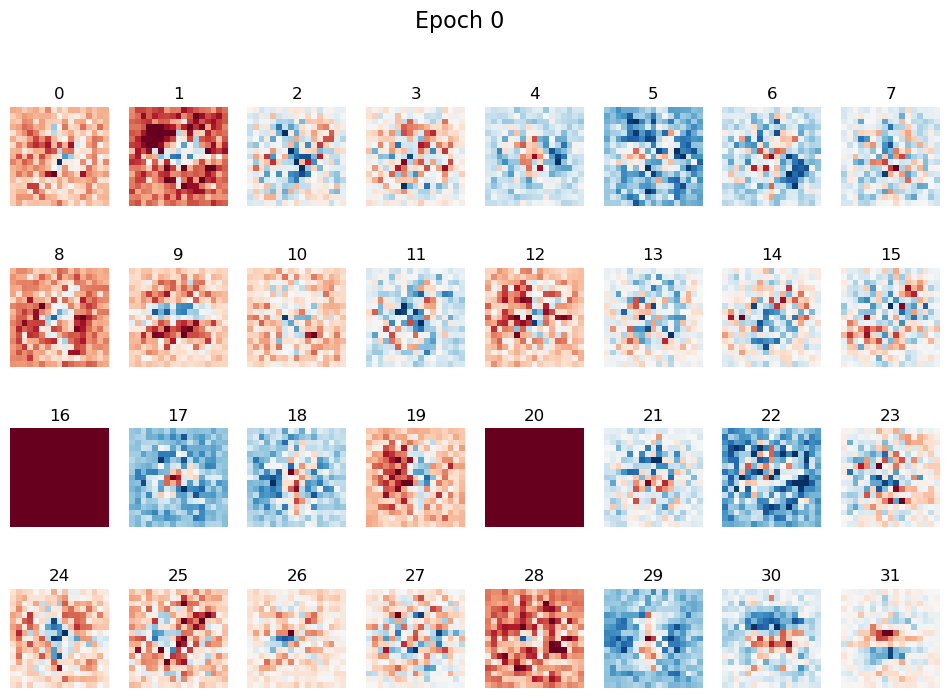

In [92]:
max_plots = 64
num_rows = max(1,min(len(epoch_effs[0]),max_plots)//8)
fig, axes = plt.subplots(num_rows, 8, figsize=(12,num_rows*2))
imshows = []
for i, (eff_rf, ax) in enumerate(zip(epoch_effs[-1][:max_plots], axes.flat)):
    imshows.append(ax.imshow(normalize(eff_rf), cmap="RdBu"))
    ax.set_title(str(i))
    ax.axis('off')
title = fig.suptitle("Epoch 0", fontsize=16)

def update(frame):
    for img, eff_rf in zip(imshows,epoch_effs[frame]):
        img.set_data(normalize(eff_rf))
    title.set_text(f"Epoch {frame}")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(epoch_effs), interval=200)
display(HTML(ani.to_jshtml()))

In [31]:
epoch_fits = []
fit_mses=np.zeros((len(epoch_effs), len(epoch_effs[0])))

for i_epoch, effs in enumerate(tqdm(epoch_effs)):
    result_generator = Parallel(n_jobs=48)(delayed(fit_gabor_filter)(normalize(eff_rf.numpy()), wavelength=None, maxiter=200) for eff_rf in effs)
    result = list(result_generator)
    fit_mses[i_epoch] = np.array([res[1] for res in result])
    epoch_fits.append([res[0] for res in result])

100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


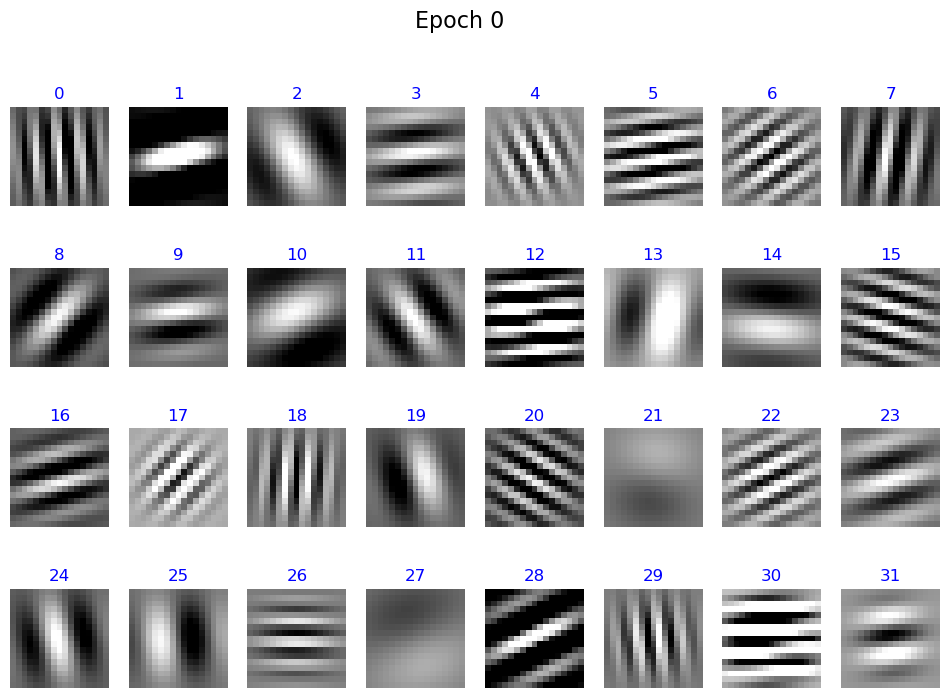

In [95]:
max_plots = 32
num_rows = max(1,min(len(epoch_fits[0]),max_plots)//8)
fig, axes = plt.subplots(num_rows, 8, figsize=(12,num_rows*2))
imshows = []
cmap = plt.get_cmap('winter_r')
good_fit=np.quantile(fit_mses[~np.isnan(fit_mses)], 0.5)

for i, (eff_rf, ax, fit_mse) in enumerate(zip(epoch_fits[-1][:max_plots], axes.flat,fit_mses[-1])):
    imshows.append(ax.imshow(eff_rf, cmap="gray"))
    ax.set_title(str(i), color=cmap(fit_mse/good_fit))
    ax.axis('off')
title = fig.suptitle("Epoch 0", fontsize=16)

def update(frame):
    for img, eff_rf, ax, fit_mse in zip(imshows,epoch_fits[frame], axes.flat, fit_mses[frame]):
        img.set_data(eff_rf)
        ax.title.set_color(cmap(fit_mse/good_fit))
    title.set_text(f"Epoch {frame}")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(epoch_fits), interval=200)
display(HTML(ani.to_jshtml()))

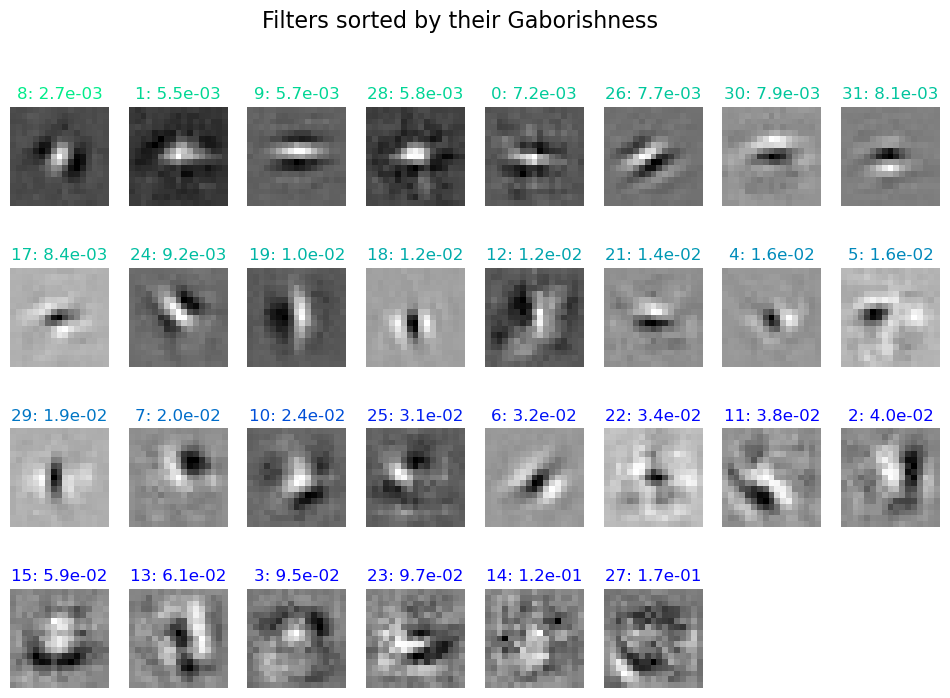

In [96]:
gaborish_rfs = np.argsort(fit_mses[-1])#np.argwhere(fit_mses[-1]<good_fit).flatten()

num_rows = max(1,np.ceil(min(len(gaborish_rfs),max_plots)/8).astype(int))
fig, axes = plt.subplots(num_rows, 8, figsize=(12,num_rows*2))

for i, eff_rf, ax, fit_mse in zip(gaborish_rfs, np.array(epoch_effs[-1])[gaborish_rfs], axes.flat,fit_mses[-1, gaborish_rfs]):
    imshows.append(ax.imshow(eff_rf, cmap="gray"))
    ax.set_title(str(i)+': {:.1e}'.format(fit_mse), color=cmap(fit_mse/good_fit))
for ax in axes.flatten():
    ax.axis('off')

title = fig.suptitle("Filters sorted by their Gaborishness", fontsize=16)
plt.show()

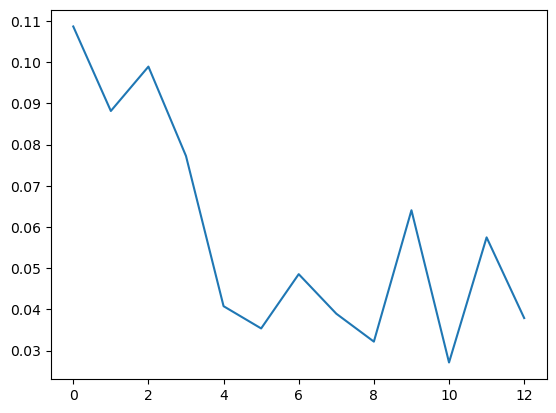

In [75]:
plt.plot(fit_mses[:,11])
plt.show()